<a href="https://colab.research.google.com/github/DrAlexSanz/CNN-in-TF/blob/master/CNN_in_Tensorlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains the implementation of a fully working CNN in Tensorflow. Not in pure Python.

In [0]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image #Image tools
import tensorflow as tf #It's a tf notebook after all
# from cnn_utils import *

%matplotlib inline

np.random.seed(1)

Load the data, I have already done this dataset in some other notebook.

In [74]:
#First remove the folder and everything it contains.

!rm -rf CNN-in-TF

#Now I clone the repository and everything works.

! git clone https://github.com/DrAlexSanz/CNN-in-TF.git

Cloning into 'CNN-in-TF'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


In [75]:
# train_X_orig, train_Y_orig, test_X_orig, test_Y_orig = load_dataset()

with h5py.File("CNN-in-TF/test_signs.h5") as test:
  test_x_1 = np.array(test["test_set_x"][:]) # your train set features
  test_y_1 = np.array(test["test_set_y"][:]) # your train set labels
  classes = np.array(test["list_classes"][:]) # the list of classes

with h5py.File("CNN-in-TF/train_signs.h5") as train:
  train_x_1 = np.array(train["train_set_x"][:]) # train set features
  train_y_1 = np.array(train["train_set_y"][:]) # train set labels

print("Everything loaded and imported")



Everything loaded and imported


Now I am going to check that I can see the images.

y = 2


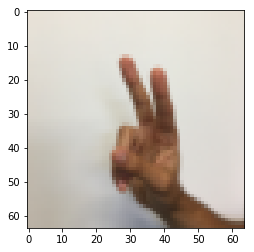

In [76]:
plt.imshow(train_x_1[645])
print("y = " + str(train_y_1[645 ]))

Now normalize and get the shapes of the dataset. Convert Y to one hot encoding. I could classify without it but I will use a softmax in the last layer, to predict [1,0,0,0,0] using a softmax function. Other than that, I could not transform it and then use an if-elif statement at the end, like my own softmax.

In [0]:
train_x = train_x_1/255
test_x = test_x_1/255

#One hot encoding by hand. I find it's a neat solution

n_classes = 5

# If I use a library, like sklearn or TF, I will fit it with the train set, and then transform BOTH, to ensure that every class is mapped consistently

#Explanation: create a nxn Identity matrix. Take the nth row. I had to write this down, it's not easy to see off the top of my head.

train_y = np.eye(n_classes+1)[train_y_1.reshape(-1)]
test_y = np.eye(n_classes+1)[test_y_1.reshape(-1)]





I need to know and check the shapes, for the placeholders and tensors later.

In [78]:
print("Number of train examples is: " + str(train_x.shape[0]))
print("Dimensions of train pictures is: " + str(train_x.shape))

print("Number of test examples is: " + str(test_x.shape[0]))
print("Dimensions of test pictures is: " + str(test_x.shape))

print("The shape of the train labels is: " + str(train_y.shape))
print("The shape of the test labels is: " + str(test_y.shape))

Number of train examples is: 1080
Dimensions of train pictures is: (1080, 64, 64, 3)
Number of test examples is: 120
Dimensions of test pictures is: (120, 64, 64, 3)
The shape of the train labels is: (1080, 6)
The shape of the test labels is: (120, 6)


Now I will make a function to create the placeholders, another to initialize the weights, another one to do the forward pass (the only one I need in tensorflow), and another to split in minibatches. Like this I can comment it out to see what happens with a full batch.

In [0]:
def create_placeholders(height, width, channels, n_classes):
    """
    the first three parameters are the dimensions of the pictures, and the last
    is the number of classes
    
    returns X and Y, two placeholders for the input and output  
    """
    
    X = tf.placeholder(tf.float32, name = "X", shape = [None, height, width, channels])
    Y = tf.placeholder(tf.float32, name = "Y", shape = [None, n_classes])
    
    # Remember, None allows me not to decide the shape now, so I can change the batch size
    
    return X,Y

In [80]:
#Check

X, Y = create_placeholders(64, 64, 3, 13)

print("X = " + str(X))
print("Y = " + str(Y))

X = Tensor("X_2:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Y_2:0", shape=(?, 13), dtype=float32)


Now I have to initialize the weights. I use Xavier initialitation. I could also use He or random. This is not so relevant, it's just a starting point for the gradient descent.